In [240]:
# Connect to google drive where we store the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [241]:
# Check if gpu is connected
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 17 17:28:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    37W / 250W |  10035MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [242]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import glob
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import imageio

import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

In [263]:
# Data preparation Hyperparameters
NUM_CLASSES = 25
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 10
HEIGHT = 320    # in the current implementation height and width both need to be divisable by 16
WIDTH  = 320

# Build DataLoaders

In [264]:
# Randomly splits a Dataset into train and test
# !!! Not used in the final version
def train_test_split(data, ratio):
    train_len = int(len(data)*ratio)
    test_len  = len(data) - train_len
    return random_split(data, [train_len, test_len])

In [265]:
# Create a custom Dataset class

class tensorDataset(Dataset):
    '''
    Inputs:
    - images: list of strings that specify paths to specific tensors
    e.g: '/Users/jedrzejalchimowicz/Desktop/DSBA - Y2S1/Deep_learning/DL_kaggle/data/train_images_96/img96_0.pt'
    - masks: same as images but for masks
    '''
    
    def __init__(self, images:list, masks:list, train:bool):
        self.image_links = images
        self.mask_links  = masks
        self.train = train
        

    def __getitem__(self, index):
        
        # Select a specific image's link
        img_id  = self.image_links[index]
        mask_id = self.mask_links[index]

        # Load the image (as tensor)
        img  = torch.load(img_id)
        mask = torch.load(mask_id)
        
        # Apply transformations
        if self.train == True:
          img, mask = self.transform(img, mask)
        
        # Squeeze mask from (1, H, W) to (H, W) -> This is because loss function accepts (B, H, W)
        mask = mask.squeeze(0)

        # Turn on gradient for image
        img = img.detach().clone().requires_grad_(True)
        mask = mask.long()
        
        return img, mask

    
    def __len__(self):
        return len(self.image_links)
    
    
    def transform(self, img, mask):
        
        # Some images in the test set are much brighter/darker than others
        temp_rand = np.random.rand()
        if temp_rand < 0.3:
            t_darken_image = T.ColorJitter(brightness=[0.6, 0.8])
            img = t_darken_image(img)
            # Do nothing for mask - the colors don't change
        elif temp_rand > 0.7:
            t_brighten_image = T.ColorJitter(brightness=[1.2, 1.4])
            img = t_brighten_image(img)
            # Do nothing for mask - the colors don't change
        
        # Flipping images makes sense for satelite images
        if np.random.rand() < 0.3:
            t_horizonal_flip = T.RandomHorizontalFlip(p=1)
            img = t_horizonal_flip(img)
            mask = t_horizonal_flip(mask)
            
        if np.random.rand() < 0.3:
            t_vertical_flip = T.RandomVerticalFlip(p=1)
            img  = t_vertical_flip(img)
            mask = t_vertical_flip(mask)

        # Add rotations
        if np.random.rand() < 0.3:
          t_rotation = T.RandomRotation(degrees=(0, 180))
          img = t_rotation(img)
          mask = t_rotation(mask)


        return img, mask

In [266]:
# Specify paths to your files (glob glob stores paths to all files in a folder in a list)
root = os.getcwd()
train_img_link_list  = sorted(glob.glob('/content/drive/MyDrive/FDL_kaggle_data/train_images_320/*'))
train_mask_link_list = sorted(glob.glob('/content/drive/MyDrive/FDL_kaggle_data/train_masks_320/*'))
val_img_link_list    = sorted(glob.glob('/content/drive/MyDrive/FDL_kaggle_data/val_images_320/*'))
val_mask_link_list   = sorted(glob.glob('/content/drive/MyDrive/FDL_kaggle_data/val_masks_320/*'))

train_dataset = tensorDataset(train_img_link_list, train_mask_link_list, train=True)
val_dataset   = tensorDataset(val_img_link_list, val_mask_link_list, train=False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset  , batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Test dataloaders
start = time.time()
for i, batch in enumerate(train_dataloader):
    img_batch, img_mask = batch
    print(img_batch.shape)
    print(img_mask.shape)

for i, batch in enumerate(val_dataloader):
    img_batch, img_mask = batch
    print(img_batch.shape)
    print(img_mask.shape)
      
end = time.time()
print(end - start)

# Architectures

## U-NET

In [268]:
# U-net is composed of several blocks with pooling in between. Each block consists of 2 convolutions,
# therefore to not repeat code at each block we define a class that summarizes it
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            )
    
    def forward(self, x):
        return self.conv(x)

In [269]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=25, features=[16, 32, 64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.downs      = nn.ModuleList()
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.ups        = nn.ModuleList()
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.pool       = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        # Down part of U-net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # Up part of U-net
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            # self.ups.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True))
            self.ups.append(DoubleConv(feature*2, feature))
            
    def forward(self, x):
        skip_connections = []
        
        # Go down the Unet
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        # Go through the bottleneck
        x = self.bottleneck(x)
        # Reverse the skip connections list -> first are going to be used the ones added last
        skip_connections = skip_connections[::-1]
        
        # Go up the Unet
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
#             #If original input shape not divisable by 16
#             if x.shape != skip_connection.shape:
#                 x = TF.resize(x, size=skip_connection.shape[2:])

            skip_connection = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](skip_connection)
        
        # Last convolution that changes channel output size
        x = self.final_conv(x)
        return x

## DeepLabV3+ & PSPNet

In [270]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

# Evaluation Metrics

In [271]:
# Define a function to calculate the Dice score
def f1_dice_score(preds, true_mask):
    '''
    https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
    preds should be (B, 25, H, W)
    true_mask should be (B, H, W)
    '''

    f1_batch = []

    for i in range(len(preds)):
        f1_image = []
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)
        
        # Change shape of img from [25, H, W] to [H, W]
        img = torch.argmax(img, dim=0)
    
        for label in range(25):
            if torch.sum(mask == label) != 0:
                area_of_intersect = torch.sum((img == label) * (mask == label))
                area_of_img       = torch.sum(img == label)
                area_of_label     = torch.sum(mask == label)
                f1 = 2*area_of_intersect / (area_of_img + area_of_label)
                f1_image.append(f1)
        
        f1_batch.append(np.mean([tensor.cpu() for tensor in f1_image]))
    return np.mean(f1_batch)
    
    
# Accuracy
def accuracy(preds, true_mask):
    '''
    preds should be (B, 25, H, W)
    true_mask should be (B, H, W)
    '''
    accuracy_batch = []

    for i in range(len(preds)):
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)
        
        # Change shape of img from [25, H, W] to [H, W]
        img  = torch.argmax(img, dim=0)
        
        accuracy_batch.append(torch.sum(img == mask).item() / (HEIGHT*WIDTH))  # FIX LATER
        
    return np.mean(accuracy_batch)



# Train function

In [272]:
def train():

  min_val_f1 = 0.3

  for epoch in range(STARTING_EPOCH+1, STARTING_EPOCH+EPOCHS+1):
      
      # Train model
      model.train()
      train_losses   = []
      train_accuracy = []
      train_f1       = []
      
      for i, batch in enumerate(train_dataloader):
          #Extract data, labels
          img_batch, mask_batch = batch   #img [B,3,H,W], mask[B,H,W]
          img_batch = img_batch.to(DEVICE)
          mask_batch = mask_batch.to(DEVICE)

          #Train model
          optimizer.zero_grad()
          # with torch.cuda.amp.autocast():
          output = model(img_batch) # output: [B, 25, H, W]
          loss   = criterion(output, mask_batch)
          loss.backward()

          # torch.nn.utils.clip_grad_norm_(model.parameters(), 6)
          optimizer.step()

          #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
          f1 = f1_dice_score(output, mask_batch)
          acc = accuracy(output, mask_batch)
          train_losses.append(loss.item())
          train_accuracy.append(acc)
          train_f1.append(f1)
          # print(f'Train Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')
      
      # Update global metrics
      print(f'TRAIN       Epoch: {epoch} | Epoch metrics | loss: {np.mean(train_losses):.4f}, f1: {np.mean(train_f1):.3f}, accuracy: {np.mean(train_accuracy):.3f}')        
      total_train_losses.append(np.mean(train_losses))
      total_train_accuracy.append(np.mean(train_accuracy))
      total_train_f1.append(np.mean(train_f1))
      
      
      # Validate model
      model.eval()
      val_losses   = []
      val_accuracy = []
      val_f1       = []
      
      for i, batch in enumerate(val_dataloader):
          #Extract data, labels
          img_batch, mask_batch = batch
          img_batch = img_batch.to(DEVICE)
          mask_batch = mask_batch.to(DEVICE)

          #Validate model
          with torch.cuda.amp.autocast():
            output = model(img_batch)
            loss   = criterion(output, mask_batch)

          #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
          f1 = f1_dice_score(output, mask_batch)
          acc = accuracy(output, mask_batch)
          val_losses.append(loss.item())
          val_accuracy.append(acc)
          val_f1.append(f1)
          
          # print(f'Val Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')
      
      # Update global metrics
      print(f'VALIDATION  Epoch: {epoch} | Epoch metrics | loss: {np.mean(val_losses):.4f}, f1: {np.mean(val_f1):.3f}, accuracy: {np.mean(val_accuracy):.3f}')
      print('---------------------------------------------------------------------------------')
      total_val_losses.append(np.mean(val_losses))
      total_val_accuracy.append(np.mean(val_accuracy))
      total_val_f1.append(np.mean(val_f1))
      
      
      # Save the model
      if np.mean(val_f1) > min_val_f1:
        torch.save(model.state_dict(), f'/content/drive/MyDrive/FDL_kaggle_data/models/PSPNet_res101_368_{epoch}.pt')
        min_val_f1 = np.mean(val_f1)
      
      # Save the results so far
      temp_df = pd.DataFrame(list(zip(total_train_losses, total_val_losses, total_train_f1, total_val_f1,
                                    total_train_accuracy, total_val_accuracy)),
                            columns = ['train_loss', 'val_loss', 'train_f1', 'test_f1', 'train_accuracy',
                                      'test_accuracy'])
      temp_df.to_csv('train_val_measures')
      

# Train workflow

In [273]:
# Initialization
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

################### UNET ###################
# model = UNET(in_channels=3, out_channels=25).to(DEVICE)
# model.load_state_dict(torch.load(f'/content/drive/MyDrive/FDL_kaggle_data/models/modelBIG_52.pt'))


############### DeepLabV3Plus ##############
# create segmentation model without pretrained encoder- DeepLabV3Plus
# model = smp.DeepLabV3Plus(
#     encoder_name = 'resnet101', 
#     encoder_weights = 'imagenet', 
#     classes = 25, 
#     activation = None, # could be None for logits or 'softmax2d' for multiclass segmentation
# ).to(DEVICE)
# model.load_state_dict(torch.load(f'/content/drive/MyDrive/FDL_kaggle_data/models/DeepLabV3Plus_80.pt'))

################## PSPNet ##################
#Creating a segmentation model with PSPNet
model = smp.PSPNet(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 25, 
    activation = None, # could be None for logits or 'softmax2d' for multiclass segmentation
).to(DEVICE)



total_train_losses   = []
total_val_losses     = []
total_train_accuracy = []
total_val_accuracy   = []
total_train_f1       = []
total_val_f1         = []

In [275]:
# HYPERPARAMETERS for training run
STARTING_EPOCH = 50
EPOCHS = 25
LR = 0.000001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss().to(DEVICE)

train()

TRAIN       Epoch: 51 | Epoch metrics | loss: 0.9919, f1: 0.327, accuracy: 0.663
VALIDATION  Epoch: 51 | Epoch metrics | loss: 0.8223, f1: 0.431, accuracy: 0.756
---------------------------------------------------------------------------------
TRAIN       Epoch: 52 | Epoch metrics | loss: 1.0008, f1: 0.328, accuracy: 0.667
VALIDATION  Epoch: 52 | Epoch metrics | loss: 0.8226, f1: 0.431, accuracy: 0.756
---------------------------------------------------------------------------------
TRAIN       Epoch: 53 | Epoch metrics | loss: 0.9279, f1: 0.335, accuracy: 0.685
VALIDATION  Epoch: 53 | Epoch metrics | loss: 0.8226, f1: 0.428, accuracy: 0.758
---------------------------------------------------------------------------------
TRAIN       Epoch: 54 | Epoch metrics | loss: 0.9706, f1: 0.335, accuracy: 0.670
VALIDATION  Epoch: 54 | Epoch metrics | loss: 0.8145, f1: 0.431, accuracy: 0.758
---------------------------------------------------------------------------------
TRAIN       Epoch: 55 | 

# Plot results

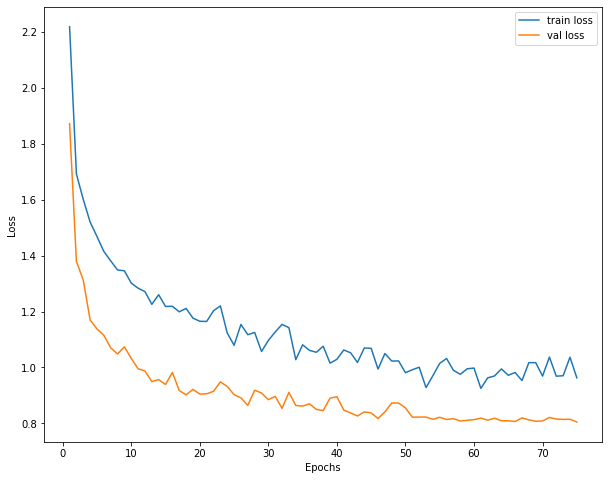

In [285]:
plt.figure(figsize=(10,8))
plt.plot(list(range(len(total_train_losses)+1))[1:120], total_train_losses[:120])
plt.plot(list(range(len(total_train_losses)+1))[1:120], total_val_losses[:120])
# plt.plot(list(range(len(total_train_losses)+1))[1:120], total_val_f1[:120])
plt.legend(['train loss', 'val loss', 'val f1'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Visualise results

In [ ]:
# Load model for which we want to visualise results
model = smp.DeepLabV3Plus(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 25, 
    activation = None, # could be None for logits or 'softmax2d' for multiclass segmentation
)

model.load_state_dict(torch.load('/content/drive/MyDrive/FDL_kaggle_data/models/DLV3Plus_368_75.pt'))

<All keys matched successfully>

In [278]:
# Get a batch from validation set
img, mask = next(iter(train_dataloader))
model.cpu()
img = img
output = model(img)

In [279]:
from matplotlib import colors

# Define function for plotting images
def show_random_images(i, img, output, true_mask):
    '''
    img <- image tensor [B,3,H,W]
    output <- output of model as [B,25,H,W] tensor
    true_mask <- mask tensor [B,H,W]
    All three elements must match, index i in img must correstpond to index i in output and true mask
    '''
    # Get preiction from output
    pred_mask  = torch.argmax(output, dim=1)
    
    # Get one image/mask only from the list, based on passed index 'i'
    img = img[i].cpu()
    pred_mask = pred_mask[i].cpu()
    true_mask = true_mask[i].cpu()
    
    # Add dummy pixels in the top left <- ensures colors assigned to each class by matplotlib match in both masks
    for i in range(24):
      pred_mask[0][i] = i
      true_mask[0][i] = i

    # Plot
    f, axarr = plt.subplots(1,3, figsize=(25,20))
    axarr[0].imshow(img.permute(1,2,0).detach().numpy())
    axarr[1].imshow(true_mask, cmap='tab20')
    axarr[2].imshow(pred_mask, cmap='tab20')

    plt.show()

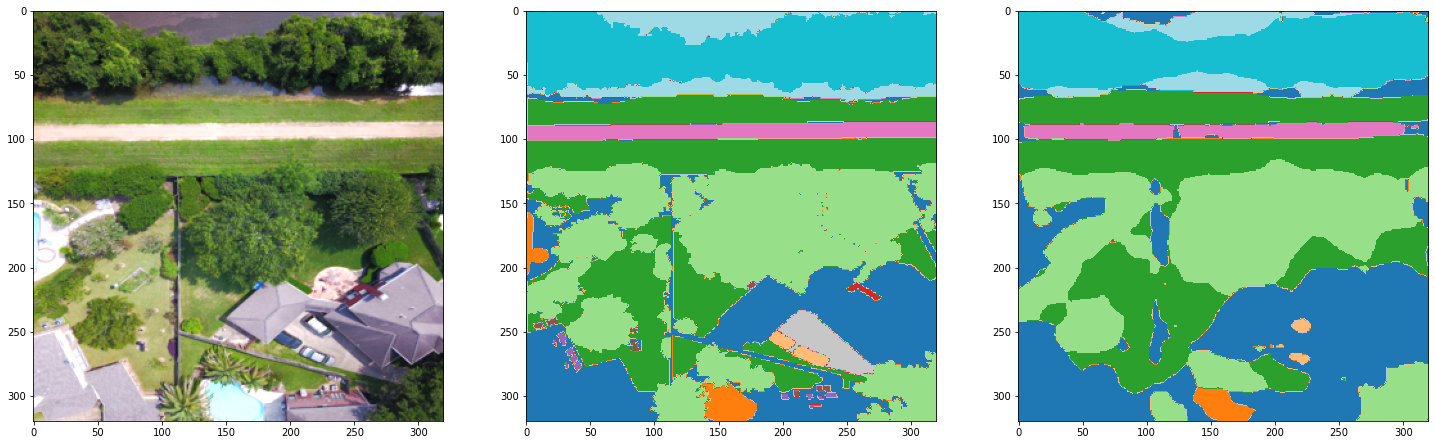

In [283]:
# LEFT: the image, MIDDLE: true mask, RIGHT: our prediction
show_random_images(1, img, output, mask)

# Submit Predictions

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load the best model
model = smp.PSPNet(
    encoder_name = 'resnet34', 
    encoder_weights = 'imagenet', 
    classes = 25, 
    activation = None, # could be None for logits or 'softmax2d' for multiclass segmentation
)

model.load_state_dict(torch.load('/content/drive/MyDrive/FDL_kaggle_data/models/PSPNet_26.pt'))

<All keys matched successfully>

In [ ]:
# Load test images
test_img_link_list = sorted(glob.glob('/content/drive/MyDrive/FDL_kaggle_data/test_images_368/*'))
torch_list = [torch.load(link) for link in test_img_link_list]

In [ ]:
# CHECK 1: how many test pictures in folder
temp = sorted(glob.glob('/content/drive/MyDrive/FDL_kaggle_data/test_images_368/*'))
len(temp)

112

In [ ]:
model.eval()

# calculate output for each image in test set and save the prediction in new folder
for i in tqdm.tqdm(range(len(torch_list))):
  img_id = test_img_link_list[i].split('/')[-1].split('.')[0]
  img = torch_list[i].unsqueeze(0)
  output = model(img)
  output = torch.argmax(output, dim=1).squeeze(0)
  output = np.uint8(output)
  output = Image.fromarray(output)
  output.save(f"/content/drive/MyDrive/FDL_kaggle_data/test_preds/{img_id}.png")

100%|██████████| 112/112 [01:24<00:00,  1.33it/s]


In [ ]:
# CHECK 2: how many predicted images in folder
temp = sorted(glob.glob('/content/drive/MyDrive/FDL_kaggle_data/test_preds/*'))
len(temp)

112

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = '/content/drive/MyDrive/FDL_kaggle_data/test_preds/'
    N = len(list(os.listdir(dir)))
    with open('submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            # print('{}/{}'.format(index, N))
                
            print(i)
            if i[0] != '.':
                mask = Image.open(dir + i)
                mask = mask.resize((1024, 1024), resample=Image.NEAREST)
                mask = np.array(mask)

                for x in range(1, 25):
                    enc = rle_encode(mask == x)
                    f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles()

10170.png
10171.png
10184.png
10566.png
10808.png
10812.png
6413.png
6424.png
6427.png
6450.png
6455.png
6457.png
6459.png
6462.png
6463.png
6465.png
6466.png
6476.png
6481.png
6492.png
6499.png
6504.png
6546.png
6550.png
6560.png
6569.png
6574.png
6608.png
6644.png
6648.png
6654.png
6656.png
6657.png
6662.png
6677.png
6701.png
6710.png
6717.png
6795.png
6804.png
6854.png
6856.png
6901.png
6908.png
6933.png
6963.png
6974.png
6982.png
6994.png
6996.png
7009.png
7193.png
7235.png
7236.png
7241.png
7251.png
7257.png
7263.png
7265.png
7270.png
7272.png
7300.png
7304.png
7308.png
7311.png
7323.png
7330.png
7356.png
7366.png
7412.png
7415.png
7422.png
7427.png
7429.png
7438.png
7457.png
7466.png
7481.png
7485.png
7489.png
7521.png
7541.png
7556.png
7560.png
7580.png
7582.png
7586.png
7593.png
7597.png
7673.png
7719.png
7721.png
7829.png
8361.png
8516.png
8526.png
8774.png
8786.png
8833.png
8906.png
8947.png
8962.png
9006.png
9070.png
9079.png
9084.png
9087.png
9101.png
9106.png
9110.png
9723

# Focal loss function

In [ ]:
from torch.autograd import Variable

# Source:
# https://github.com/doiken23/pytorch_toolbox/blob/master/focalloss2d.py


class FocalLoss2d(nn.Module):

    def __init__(self, gamma=0, weight=None, size_average=True):
        super(FocalLoss2d, self).__init__()

        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.contiguous().view(input.size(0), input.size(1), -1)
            input = input.transpose(1,2)
            input = input.contiguous().view(-1, input.size(2)).squeeze()
        if target.dim()==4:
            target = target.contiguous().view(target.size(0), target.size(1), -1)
            target = target.transpose(1,2)
            target = target.contiguous().view(-1, target.size(2)).squeeze()
        elif target.dim()==3:
            target = target.view(-1)
        else:
            target = target.view(-1, 1)

        # compute the negative likelyhood
        weight = Variable(self.weight)
        logpt = -F.cross_entropy(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        loss = -((1-pt)**self.gamma) * logpt

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()